In [14]:
import sys,os
import csv
import pickle
import scipy
import numpy as np
import json
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# (Party,Year) Reshufflings

In this nb we will compare the correlations of the Pop. Score with expert-based scores with the same correlations computed using the Pop. Score computed with the reshuffled datasets. 

We created these datasets by randomly reassing the __(party, year)__ label of each manifesto for each nation.

We will also compare the normal and reshuffled correlations with the Manual Coding data for the Italian Case only.


In [15]:
def pearsons_whole_stats(x,y):
    """
    This function computes the pearson's correlation coefficient between two variables x and y.
    It also computes the relative confidence interval from 5th to 95th percentile, and returns
    the p-value of the null hypothesis that the correlation coefficient is 0.
    """

    r, p = scipy.stats.pearsonr(x,y)

    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = scipy.stats.norm.ppf(1-alpha/2)

    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))

    output = {"coeff":r, "p_value":p, "lo":lo, "hi":hi}
    
    return output


def map_to_orientation(lrgen):
    """
    This function classifies parties' political orientations using the "lrgen" field of CHES 2017
    """
    
    if lrgen<4: return "Left-wing"
    elif lrgen<6: return "Other"
    else: return "Right-wing"
    
    
populist_parties = {
    "IT":['Northern League', 'PaP', 'M5S', 'Brothers of Italy'],

    "FR":['National Front','Indomitable France'],
    "AT":['Austrian Freedom Party','Alliance for the Future of Austria','Team Stronach for Austria'],

    "NL":['Party of Freedom','List Pim Fortuyn','Socialist Party','Forum for Democracy'],
    "ES":['We can','In Common We Can',"Vox"],
    "DE":['The Left','Alternative for Germany']
    
}

parties_to_exclude = {
    "IT":['Forward Italy', 'PdL', 'Italy of Values', 'Casapound', 'Houses of Freedom'],

    "FR":['The Greens','French Communist Party', "Nouveau Parti Anticapitaliste", "Resistons",'Debout la France'],
    "AT":['Peter Pilz List'],

    "NL":['DENK','Party for the Animals','Reformed Political Party','50Plus','Green Left'],
    "ES":["Citizens"],
    "DE":['Pirates']
}

# Loading Scores

In [16]:
nations = [ "IT","FR", "ES", "DE", "NL", "AT"]

df_global_scores = None

for nation in nations:
    
    if df_global_scores is None:
        df_global_scores = pd.read_csv("./scores/global_scores_{}.csv".format(nation))
        df_global_scores["nation"] = nation
        df_global_scores["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores.party.values]
    else:
        df_global_scores_aux = pd.read_csv("./scores/global_scores_{}.csv".format(nation))
        df_global_scores_aux["nation"] = nation
        df_global_scores_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores_aux.party.values]
        df_global_scores = pd.concat([df_global_scores,df_global_scores_aux], axis=0)
        
df_global_scores.index = range(len(df_global_scores))
df_global_scores = df_global_scores.iloc[df_global_scores.score.sort_values(ascending=False).index]
df_global_scores.index = range(len(df_global_scores))
df_global_scores.head(n=10)

,party,score,orientation,counts,nation,isExcluded
0,Casapound,0.894737,Right-wing,38,IT,True
1,In Common We Can,0.889788,Left-wing,1606,ES,False
2,Commitment-We can-It is time,0.815891,Left-wing,2064,ES,False
3,PaP,0.750000,Left-wing,12,IT,False
4,M5S,0.729730,Other,259,IT,False
5,Democracy and Freedom,0.690625,Right-wing,640,ES,False
6,Indomitable France,0.643505,Left-wing,331,FR,False
7,National Front,0.626033,Right-wing,484,FR,False
8,Convergence and Union,0.621988,Other,664,ES,False
9,Forward Italy,0.600000,Right-wing,15,IT,True


In [17]:
nations = [ "IT","FR", "ES", "AT", "DE", "NL"]

df_scores_in_time = None

for nation in nations:
    
    if df_scores_in_time is None:
        df_scores_in_time = pd.read_csv("./scores/scores_in_time_{}.csv".format(nation))
        df_scores_in_time["nation"] = nation
        df_scores_in_time["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time.party.values]

    else:
        df_scores_in_time_aux = pd.read_csv("./scores/scores_in_time_{}.csv".format(nation))
        df_scores_in_time_aux["nation"] = nation
        df_scores_in_time_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time_aux.party.values]

        df_scores_in_time = pd.concat([df_scores_in_time,df_scores_in_time_aux], axis=0)
df_scores_in_time = df_scores_in_time.rename(columns={"nation":"country_name"})
df_scores_in_time["party_country_name"] = [party+"_"+country_name for party, country_name in df_scores_in_time[["party","country_name"]].values]
       
df_scores_in_time.head(n=10)

,party,year,score,orientation,counts,country_name,isExcluded,party_country_name
0,M5S,2018.0,0.900498,Other,201,IT,False,M5S_IT
1,Communist Refoundation Party,2001.0,0.060359,Left-wing,613,IT,False,Communist Refoundation Party_IT
2,PD,2013.0,0.058824,Left-wing,68,IT,False,PD_IT
3,The Olive Tree,2001.0,0.143836,Left-wing,146,IT,False,The Olive Tree_IT
4,Northern League,2018.0,0.553299,Right-wing,197,IT,False,Northern League_IT
5,Brothers of Italy,2018.0,0.416667,Right-wing,12,IT,False,Brothers of Italy_IT
6,Northern League,2008.0,0.279070,Right-wing,86,IT,False,Northern League_IT
7,SEL,2013.0,0.082927,Left-wing,205,IT,False,SEL_IT
8,SVP,2013.0,0.004149,Left-wing,241,IT,False,SVP_IT
9,PD,2018.0,0.336134,Left-wing,119,IT,False,PD_IT


# Loading Reshuffled Scores

In [18]:
nations = [ "IT","FR", "ES", "DE", "NL", "AT"]

df_global_scores_resh = None

for nation in nations:
    
    if df_global_scores is None:
        df_global_scores_resh = pd.read_csv("./scores_resh/global_scores_{}.csv".format(nation))
        df_global_scores_resh["nation"] = nation
        df_global_scores_resh["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores_resh.party.values]

    else:
        df_global_scores_resh_aux = pd.read_csv("./scores_resh/global_scores_{}.csv".format(nation))
        df_global_scores_resh_aux["nation"] = nation
        df_global_scores_resh_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores_resh_aux.party.values]

        df_global_scores_resh = pd.concat([df_global_scores_resh,df_global_scores_resh_aux], axis=0)
        
df_global_scores_resh.index = range(len(df_global_scores_resh))
df_global_scores_resh = df_global_scores_resh.iloc[df_global_scores_resh.score.sort_values(ascending=False).index]
df_global_scores_resh.index = range(len(df_global_scores_resh))
df_global_scores_resh.head(n=10)

,party,score,orientation,counts,random_state,nation,isExcluded
0,Democratic Center,1.0,Other,3,40,IT,False
1,SVP,1.0,Left-wing,3,99,IT,False
2,Brothers of Italy,1.0,Right-wing,257,18,IT,False
3,SVP,1.0,Left-wing,5,24,IT,False
4,Autonomy Liberty Participation Ecology,1.0,Other,1,80,IT,False
5,Communist Refoundation Party,1.0,Left-wing,3,28,IT,False
6,The Union,1.0,Left-wing,2,82,IT,False
7,SEL,1.0,Left-wing,5,30,IT,False
8,Civic Choice,1.0,Left-wing,1,85,IT,False
9,Civic Choice,1.0,Left-wing,1,37,IT,False


In [19]:
nations = [ "IT","FR", "ES", "AT", "DE", "NL"]

df_scores_in_time_resh = None

for nation in nations:
    
    if df_scores_in_time_resh is None:
        df_scores_in_time_resh = pd.read_csv("./scores_resh/scores_in_time_{}.csv".format(nation))
        df_scores_in_time_resh["nation"] = nation
        df_scores_in_time_resh["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time_resh.party.values]

    else:
        df_scores_in_time_resh_aux = pd.read_csv("./scores_resh/scores_in_time_{}.csv".format(nation))
        df_scores_in_time_resh_aux["nation"] = nation
        df_scores_in_time_resh_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time_resh_aux.party.values]

        df_scores_in_time_resh = pd.concat([df_scores_in_time_resh,df_scores_in_time_resh_aux], axis=0)

df_scores_in_time_resh = df_scores_in_time_resh.rename(columns={"nation":"country_name"})
df_scores_in_time_resh["party_country_name"] = [party+"_"+country_name for party, country_name in df_scores_in_time_resh[["party","country_name"]].values]

df_scores_in_time_resh.head(n=10)

,party,year,score,orientation,counts,random_state,country_name,isExcluded,party_country_name
0,PaP,2018.0,0.428571,Left-wing,70,0,IT,False,PaP_IT
1,PD,2013.0,0.076923,Left-wing,585,0,IT,False,PD_IT
2,LeU,2018.0,0.087591,Left-wing,137,0,IT,False,LeU_IT
3,SEL,2013.0,0.102740,Left-wing,146,0,IT,False,SEL_IT
4,Autonomy Liberty Participation Ecology,2013.0,0.459091,Other,220,0,IT,False,Autonomy Liberty Participation Ecology_IT
5,M5S,2018.0,0.462687,Other,201,0,IT,False,M5S_IT
6,UDC,2013.0,0.233333,Other,30,0,IT,False,UDC_IT
7,SVP,2013.0,0.191011,Left-wing,89,0,IT,False,SVP_IT
8,Democratic Center,2013.0,0.130435,Other,69,0,IT,False,Democratic Center_IT
9,The Union,2006.0,0.061947,Left-wing,113,0,IT,False,The Union_IT


# Correlations with CHES

In [20]:
def pearsons_whole_stats(x,y):
    """
    This function computes the pearson's correlation coefficient between two variables x and y.
    It also computes the relative confidence interval from 5th to 95th percentile, and returns
    the p-value of the null hypothesis that the correlation coefficient is 0.
    """

    r, p = scipy.stats.pearsonr(x,y)

    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = scipy.stats.norm.ppf(1-alpha/2)

    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))

    output = {"coeff":r, "p_value":p, "lo":lo, "hi":hi}
    
    return output


def map_to_orientation(lrgen):
    """
    This function classifies parties' political orientations using the "lrgen" field of CHES 2017
    """
    
    if lrgen<4: return "Left-wing"
    elif lrgen<6: return "Other"
    else: return "Right-wing"


In [21]:
print("reading CHES data..")
df_ches = pd.read_csv("./CHES_data/CHES_means_2017.csv")
df_ches = df_ches[['country', 'year','party','people_vs_elite', 'antielite_salience', "lrgen"]].copy()


country_mapping = {
    "ger":"DE",
    "it":"IT",
    "fr":"FR",
    "nl":"NL",
    "esp":"ES",
}

party_mapping = {
    
    "DE":{
        "CDU":"Christian Democratic Union-Christian Social Union",
        "SPD":"Social Democratic Party of Germany",
        "Grunen":"Alliance‘90-Greens",
        "Linke":"The Left",
        "AfD":"Alternative for Germany",
    },
    
    "IT":{
        "LN":"Northern League",
        "UDC":"UDC",
        "PD":"PD",
        "CD":"Democratic Center",
        "FdI":"Brothers of Italy",
        "M5S":"M5S",
    },
    
    "FR":{
        "PCF":"French Communist Party",
        "PS":"Socialist Party",
        "EELV":"The Greens",
        "LR":"Union for a Popular Movement",
        "FN":"National Front",
        "MODEM":"Democratic Mouvement",
        "LREM":"Republic Onwards!",
        "Insoumis":"Indomitable France",
        "DLF":"Debout la France",
    },
    
    "ES":{
        "PSOE":"Spanish Socialist Workers’ Party",
        "PP":"People's Party",
        "IU":"United Left",
        "Podemos":"We can",
    },
    
    "NL":{
        "CDA":"Christian Democratic Appeal",
        "PvdA":"Labour Party",
        "VVD":"People’s Party for Freedom and Democracy",
        "D66":"Democrats‘66",
        "GL":"Green Left",
        "SGP":"Reformed Political Party",
        "SP":"Socialist Party",
        "CU":"Christian Union",
        "PVV":"Party of Freedom",
        "PvdD":"Party for the Animals",
        "50PLUS":"50Plus",
        "Denk":"DENK",
        "FvD":"Forum for Democracy"
    },
    
}

print("changing country identifiers...")
df_ches = df_ches[df_ches.country.isin(country_mapping.keys())].copy()
df_ches["country"] = [country_mapping[country] for country in df_ches.country]
df_ches = df_ches.rename(columns={"country":"nation"})
##############
print("mapping CHES party names to our notation...")
for nation in party_mapping:
    new_party = []
    for party in df_ches.loc[df_ches.nation==nation, "party"].values:
        try: new_party.append(party_mapping[nation][party])
        except KeyError: new_party.append( "missing")
    df_ches.loc[df_ches.nation==nation, "party"] =new_party

df_ches = df_ches[df_ches.party != "missing"]
##############
print("merging dataframes..")
df_ches = pd.merge(df_ches,df_global_scores, on=["nation", "party"], how="left",suffixes=("_ches","_score") )
df_ches = df_ches.dropna()
df_ches["orientation_ches"] = [map_to_orientation(lrgen) for lrgen in df_ches.lrgen.values]


reading CHES data..
changing country identifiers...
mapping CHES party names to our notation...
merging dataframes..


Score vs people_vs_elite
	 Corr. coeff = 0.715 with CI [0.509,0.844], p-value = 0.0
Score vs antielite_salience
	 Corr. coeff = 0.816 with CI [0.669,0.902], p-value = 0.0


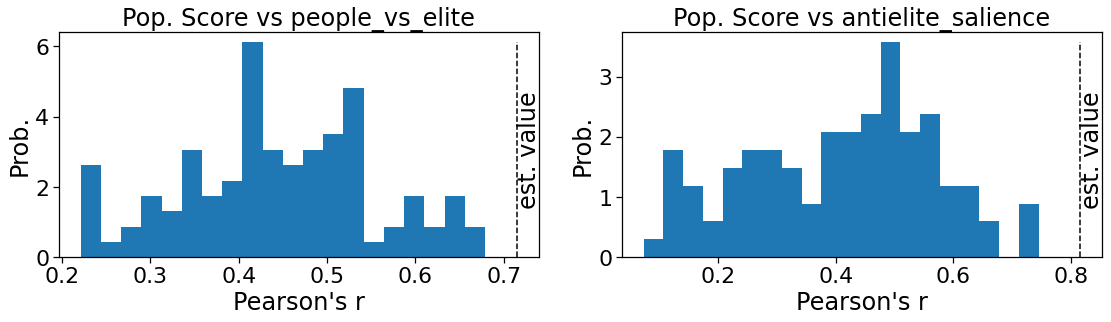

In [22]:
sns.set_context("notebook", font_scale=2)
fig,axs = plt.subplots(figsize=(16,5), ncols=2)

for i, var in enumerate(["people_vs_elite","antielite_salience"]):

    res = pearsons_whole_stats(df_ches.score.values, df_ches[var].values)
    res = {k:round(res[k],3) for k in res}
    print("Score vs {}".format(var))
    print("\t Corr. coeff = {0} with CI [{1},{2}], p-value = {3}".format(res["coeff"], res["lo"], res["hi"], res["p_value"]))

    ###########################

    r_resh_list = []
    p_values_list = []
    for random_state in sorted(df_global_scores_resh.random_state.unique()):
        df_global_scores_resh_aux = df_global_scores_resh[df_global_scores_resh.random_state==random_state]
        df_ches_with_resh = pd.merge(df_ches,df_global_scores_resh_aux[["nation","party","score"]], on=["nation", "party"], how="left",suffixes=("","_resh{}".format(random_state)) )

        res_resh = pearsons_whole_stats(df_ches_with_resh["score_resh{}".format(random_state)].values, df_ches_with_resh[var].values)
        r_resh_list.append(res_resh["coeff"])
        p_values_list.append(res_resh["p_value"])

    ###########################

    ax = axs.flatten()[i]
    ax.set_title("Pop. Score vs {}".format(var))
    hist = ax.hist(r_resh_list,bins=20, density=True)
    ax.set_xlabel("Pearson's r")
    ax.set_ylabel("Prob.")

    v_up = hist[0].max()
    ax.vlines(res["coeff"],0,v_up, color="black", linestyle="dashed")
    ax.text(res["coeff"], v_up/4, "est. value", rotation=90)
    
plt.tight_layout()
plt.savefig("./figures/ches_reshufflings.png", dpi=300)

# Correlation with latent variable

In [23]:
print("reading POPPA dataset...")
df_poppa = pd.read_csv("./POPPA_data/poppa_and_latent_variable.csv")
df_poppa = df_poppa[["country_id","party",'peoplecentrism',\
         'manichean','indivisble','generalwill','antielitism',"latent", "lroverall"]]

country_mapping = {
    "GE":"DE",
    "IT":"IT",
    "FR":"FR",
    "NL":"NL",
    "SP":"ES",
    "AU":"AT",

}


party_mapping = {
    
    "DE":{
        "CDU":"Christian Democratic Union-Christian Social Union",
        "SPD":"Social Democratic Party of Germany",
        "B90Grune":"Alliance‘90-Greens",
        "Linke":"The Left",
        "AfD":"Alternative for Germany",
    },
    
    "IT":{
        "LN":"Northern League",
        "UDC":"UDC",
        "PD":"PD",
        "CD":"Democratic Center",
        "FdlCN":"Brothers of Italy",
        "M5S":"M5S",
    },
    
    "FR":{
        "PCF":"French Communist Party",
        "PS":"Socialist Party",
        "EELV":"The Greens",
        "LR":"Union for a Popular Movement",
        "FN":"National Front",
        "MoDem":"Democratic Mouvement",
        "LaREM":"Republic Onwards!",
        "LFI":"Indomitable France",
        "DLF":"Debout la France",
        "NPA":"Nouveau Parti Anticapitaliste"
    },
    
    "ES":{
        "PSOE":"Spanish Socialist Workers’ Party",
        "PP":"People's Party",
        "Podemos":"We can",
    },
    
    "NL":{
        "CDA":"Christian Democratic Appeal",
        "PvdA":"Labour Party",
        "VVD":"People’s Party for Freedom and Democracy",
        "D66":"Democrats‘66",
        "GL":"Green Left",
        "SGP":"Reformed Political Party",
        "SP":"Socialist Party",
        "CU":"Christian Union",
        "PVV":"Party of Freedom",
        "PvdD":"Party for the Animals",
        "50Plus":"50Plus",
        "DENK":"DENK",
        "FvD":"Forum for Democracy",
    },
    
    
    "AT":{
        'PILZ':"Peter Pilz List",
        "FPO":"Austrian Freedom Party",
        "Gruene": "The Greens",
        "NEOS": "The New Austria",
        "OVP": "Austrian People’s Party",
        "SPO":"Austrian Social Democratic Party"
    }
    
}

##############
print("changing country identifiers...")
df_poppa = df_poppa[df_poppa.country_id.isin(country_mapping.keys())].copy()
df_poppa["country_id"] = [country_mapping[country] for country in df_poppa.country_id]
df_poppa = df_poppa.rename(columns={"country_id":"nation"})
##############
print("mapping POPPA party names to our notation...")

df_poppa["old_party"] = [party for party in df_poppa.party]
for nation in party_mapping:
    new_party = []
    for party in df_poppa.loc[df_poppa.nation==nation, "party"].values:
        try: new_party.append(party_mapping[nation][party])
        except KeyError: new_party.append( "missing")
    df_poppa.loc[df_poppa.nation==nation, "party"] =new_party

df_poppa = df_poppa[df_poppa.party != "missing"]
##############

print("merging dataframes..")
df_poppa = pd.merge(df_poppa,df_global_scores, on=["nation", "party"], how="left",suffixes=("_poppa","_score") )
df_poppa["orientation_poppa"] = [map_to_orientation(lroverall) for lroverall in df_poppa.lroverall.values]
##############

reading POPPA dataset...
changing country identifiers...
mapping POPPA party names to our notation...
merging dataframes..


	 Corr. coeff = 0.818 with CI [0.683,0.9], p-value = 0.0


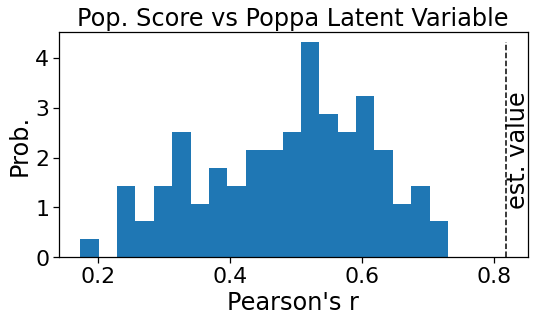

In [24]:
res = pearsons_whole_stats(df_poppa.score.values, df_poppa.latent.values)
res = {k:round(res[k],3) for k in res}
print("\t Corr. coeff = {0} with CI [{1},{2}], p-value = {3}".format(res["coeff"], res["lo"], res["hi"], res["p_value"]))

###########################

r_resh_list = []
p_values_list = []
for random_state in sorted(df_global_scores_resh.random_state.unique()):
    df_global_scores_resh_aux = df_global_scores_resh[df_global_scores_resh.random_state==random_state]
    df_poppa_with_resh = pd.merge(df_poppa,df_global_scores_resh_aux[["nation","party","score"]], on=["nation", "party"], how="left",suffixes=("","_resh{}".format(random_state)) )

    res_resh = pearsons_whole_stats(df_poppa_with_resh["score_resh{}".format(random_state)].values, df_poppa_with_resh.latent.values)
    r_resh_list.append(res_resh["coeff"])
    p_values_list.append(res_resh["p_value"])

###########################

sns.set_context("notebook", font_scale=2)
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)

ax.set_title("Pop. Score vs Poppa Latent Variable")
hist = ax.hist(r_resh_list,bins=20, density=True)
ax.set_xlabel("Pearson's r")
ax.set_ylabel("Prob.")

v_up = hist[0].max()
ax.vlines(res["coeff"],0,v_up, color="black", linestyle="dashed")
ax.text(res["coeff"], v_up/4, "est. value", rotation=90)

    
plt.tight_layout()
plt.savefig("./figures/poppa_reshufflings.png", dpi=300)

# Corr. with Manual Coding

In [28]:
df_IT_manual = pd.read_csv("./scores/global_scores_IT_manual.csv")
df_IT = df_global_scores[df_global_scores.nation=="IT"]
df_IT_resh = df_global_scores_resh[df_global_scores_resh.nation=="IT"]
df_merged = pd.merge(df_IT,df_IT_manual, on = ["party"], suffixes=("", "_manual"))

	 Corr. coeff = 0.857 with CI [0.668,0.942], p-value = 0.0


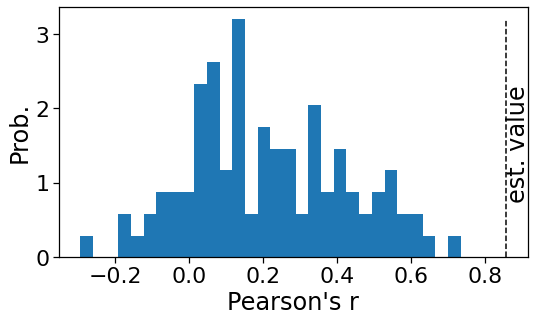

In [29]:
res = pearsons_whole_stats(df_merged.score_manual.values, df_merged.score.values)
res = {k:round(res[k],3) for k in res}
print("\t Corr. coeff = {0} with CI [{1},{2}], p-value = {3}".format(res["coeff"], res["lo"], res["hi"], res["p_value"]))


r_resh_list = []
p_values_list = []
for random_state in sorted(df_IT_resh.random_state.unique()):
    df_IT_resh_aux = df_IT_resh[df_IT_resh.random_state==random_state]
    df_merged_with_resh = pd.merge(df_merged,df_IT_resh_aux[["nation","party","score"]], on=["nation", "party"], how="left",suffixes=("","_resh{}".format(random_state)) )
    df_merged_with_resh = df_merged_with_resh.dropna()
    res_resh = pearsons_whole_stats(df_merged_with_resh["score_resh{}".format(random_state)].values, df_merged_with_resh.score_manual.values)
    r_resh_list.append(res_resh["coeff"])
    p_values_list.append(res_resh["p_value"])

sns.set_context("notebook", font_scale=2)
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)
hist = ax.hist(r_resh_list,bins=30, density=True)
ax.set_xlabel("Pearson's r")
ax.set_ylabel("Prob.")

v_up = hist[0].max()
ax.vlines(res["coeff"],0,v_up, color="black", linestyle="dashed")
ax.text(res["coeff"], v_up/4, "est. value", rotation=90)

plt.tight_layout()
plt.savefig("./figures/IT_manual_coding_reshufflings.png", dpi=300)